In [34]:
import os
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from dotenv import load_dotenv
# Load the API key from the .env file
load_dotenv()
IBM_TOKEN = os.getenv('IBM_TOKEN')
IBMQ.delete_account()
IBMQ.save_account(IBM_TOKEN)
IBMQ.load_account()

# Define functions to simplify interactions with quantum computers
def get_quantum_computer(qubits=2, simulation=False, verbose=False):
    # Finds a quantum computer at IBM with the lowest queue as long as it has enough qubits for the circuit
    if simulation == False: # Execute the circuit on a quantum computer at IBM
        lowest = float('inf')
        provider = IBMQ.get_provider(hub='ibm-q')
        for backend in provider.backends():
            try:
                if "simulator" not in backend.name():
                    queue = backend.status().pending_jobs
                    qubit_count = len(backend.properties().qubits)
                    if qubit_count >= qubits:
                        if queue < lowest:
                            lowest = queue
                            quantum_computer = provider.get_backend(backend.name())
                        if verbose == True:
                            print(f"Quantum Computer {backend.name()} has {queue} queued jobs and {qubit_count} qubits")
                    else:
                        if verbose == True:
                            print(f"Quantum Computer {backend.name()} has {qubit_count} qubits, but we need {qubits} qubits")
            except:
                print(f"Quantum Computer {backend.name()} is not operational")
        if quantum_computer is None:
            print(f"No Quantum Computers available with {qubits} qubits, using simulator")
    if simulation == True or quantum_computer is None: # Execute the circuit on the simulator
        quantum_computer = Aer.get_backend('qasm_simulator')
        if verbose == True:
            print(f"Using Quantum Computer Simulator")
    if verbose == True and simulation == False:
        print(f"Using Quantum Computer: {quantum_computer.name()} with {quantum_computer.status().pending_jobs} queued jobs")
    return quantum_computer

def prepare_quantum_circuit(qubits=2, classical_bits=2, simulation=False, verbose=False):
    # Create registers for the circuit
    quantum_register = QuantumRegister(qubits)
    classical_register = ClassicalRegister(classical_bits)
    # Create a Quantum Circuit
    quantum_circuit = QuantumCircuit(quantum_register, classical_register)
    # Get a quantum computer with at least the number of selected qubits for the circuit and the lowest queue, or the simulator
    quantum_computer = get_quantum_computer(qubits=qubits, simulation=simulation, verbose=verbose)
    return quantum_circuit, quantum_register, classical_register, quantum_computer

def execute_quantum_circuit(quantum_circuit, quantum_computer, shots=500, verbose=False):
    queue_position = quantum_computer.status().pending_jobs + 1
    if verbose == True:
        print(f"Your job is number {queue_position} in the queue on {quantum_computer.name()}.  Please wait...")
    result = execute(quantum_circuit, backend=quantum_computer, shots=shots).result()
    counts = result.get_counts(quantum_circuit)
    if verbose == True:
        print(f"{result.status} in {result.time_taken} seconds on {quantum_computer.name()}")
    highest_probable = result.get_counts(quantum_circuit).most_frequent()
    if verbose == True:
        probability = 100 * float(result.get_counts(quantum_circuit)[highest_probable])/float(shots)
        print(f"The probable result was {highest_probable} with {probability}% probability")
    return highest_probable, result, counts

def bell_state_circuit(quantum_circuit, quantum_register, classical_register):
    # Build a Bell State circuit
    # https://en.wikipedia.org/wiki/Bell_state
    quantum_circuit.h(quantum_register[0])
    quantum_circuit.cx(quantum_register[0], quantum_register[1])
    quantum_circuit.measure(quantum_register, classical_register)
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

ibmqfactory.load_account:WARNING:2023-01-09 14:12:37,850: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
# Set up the circuit
quantum_circuit, quantum_register, classical_register, quantum_computer = prepare_quantum_circuit(qubits=2, classical_bits=2, simulation=False, verbose=True)
# Build a Bell State circuit
quantum_circuit, drawing = bell_state_circuit(quantum_circuit, quantum_register, classical_register)
drawing

Quantum Computer ibmq_lima has 7 queued jobs and 5 qubits
Quantum Computer ibmq_belem has 11 queued jobs and 5 qubits
Quantum Computer ibmq_quito has 15 queued jobs and 5 qubits
Quantum Computer ibmq_manila has 88 queued jobs and 5 qubits
Quantum Computer ibm_nairobi has 43 queued jobs and 7 qubits
Quantum Computer ibm_oslo has 23 queued jobs and 7 qubits
Using Quantum Computer: ibmq_lima with 6 queued jobs


┌───┐     ┌─┐   
q30_0: ┤ H ├──■──┤M├───
       └───┘┌─┴─┐└╥┘┌─┐
q30_1: ─────┤ X ├─╫─┤M├
            └───┘ ║ └╥┘
 c9: 2/═══════════╩══╩═
                  0  1

In [36]:
# Execute the circuit
highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=500, verbose=True)

Your job is number 7 in the queue on ibmq_lima.  Please wait...
Successful completion in 2.763986587524414 seconds on ibmq_lima
The probable result was 00 with 52.6% probability


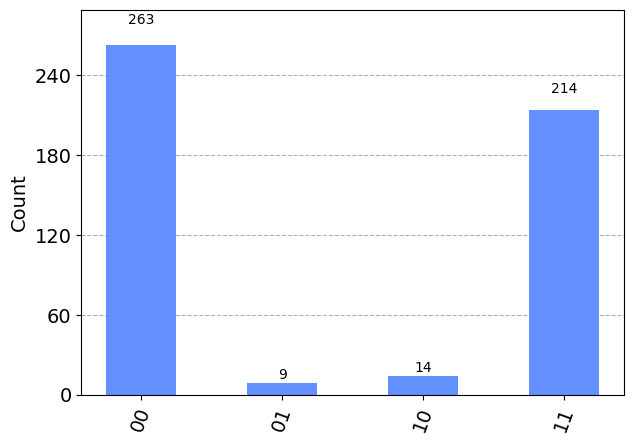

In [37]:
# Plot the results
plot_histogram(counts)